In [1]:
import tensorflow as tf
import librosa
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import skimage.io as io
import pandas as pd
import os
%load_ext tensorboard

In [122]:
batch_size = 32

img_width = 512
img_height = 128

train_directory = 'data/GTZAN/mel_images/train'
test_directory = 'data/GTZAN/mel_images/test'

train_ds = tf.keras.utils.image_dataset_from_directory(directory=train_directory,
                                                       validation_split=0.2,
                                                       subset='training',
                                                       labels=None,
                                                       seed=42,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                       color_mode='grayscale'
                                                        )

val_ds = tf.keras.utils.image_dataset_from_directory(directory=test_directory,
                                                     validation_split=0.2,
                                                     subset='validation',
                                                     labels=None,
                                                     seed=42,
                                                     image_size=(img_height, img_width),
                                                     batch_size=batch_size,
                                                     color_mode='grayscale'
                                                    )

Found 800 files belonging to 1 classes.
Using 640 files for training.
Found 199 files belonging to 1 classes.
Using 39 files for validation.


In [3]:
def augment_using_ops(images):
    scale=1./255
    images=images*scale
    return images

train_ds = train_ds.cache().map(augment_using_ops, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().map(augment_using_ops, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [125]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, Reshape, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

kernel_size = (3,3)
strides = 2


class Autoencoder(tf.keras.Model):
    
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([
            Conv2D(input_shape=(img_height, img_width, 1), filters=32, kernel_size=kernel_size, padding="same", strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=64, kernel_size=kernel_size, padding="same", strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=128, kernel_size=kernel_size, padding="same", strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=256, kernel_size=kernel_size, padding="same",strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Flatten(),
            Dense(units=latent_dim,)
        ])
        self.decoder = Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            Dense(units=65536, activation='relu'),
            BatchNormalization(axis=-1),
            Reshape(target_shape=(8,32,256)),
            Conv2DTranspose(filters=256, kernel_size=kernel_size, strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=128, kernel_size=kernel_size, strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=64, kernel_size=kernel_size,  strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=32, kernel_size=kernel_size,  strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=1, kernel_size=kernel_size, padding="same"),
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Autoencoder(256)

In [126]:
for layer in autoencoder.layers:
    for sublayer in layer.layers:
        print(sublayer.output_shape)

(None, 64, 256, 32)
(None, 64, 256, 32)
(None, 32, 128, 64)
(None, 32, 128, 64)
(None, 16, 64, 128)
(None, 16, 64, 128)
(None, 8, 32, 256)
(None, 8, 32, 256)
(None, 65536)
(None, 256)
(None, 65536)
(None, 65536)
(None, 8, 32, 256)
(None, 16, 64, 256)
(None, 16, 64, 256)
(None, 32, 128, 128)
(None, 32, 128, 128)
(None, 64, 256, 64)
(None, 64, 256, 64)
(None, 128, 512, 32)
(None, 128, 512, 32)
(None, 128, 512, 1)


In [118]:
steps_per_epoch = len(train_ds)

validation_steps = len(val_ds)

opt = Adam(learning_rate=1e-3)

In [119]:
autoencoder.compile(optimizer=opt, loss="binary_crossentropy")
hist = autoencoder.fit(
    zip(train_ds.repeat(), train_ds.repeat()),
    steps_per_epoch=steps_per_epoch,
    epochs=300,
    shuffle=True,
)

Epoch 1/300
20/20 [==============================] - 28s 1s/step - loss: 4.6049
Epoch 2/300
20/20 [==============================] - 25s 1s/step - loss: 2.5075
Epoch 3/300
20/20 [==============================] - 28s 1s/step - loss: 1.3877
Epoch 4/300
20/20 [==============================] - 26s 1s/step - loss: 1.1389
Epoch 5/300
20/20 [==============================] - 26s 1s/step - loss: 1.0881
Epoch 6/300
20/20 [==============================] - 26s 1s/step - loss: 1.0499
Epoch 7/300
20/20 [==============================] - 28s 1s/step - loss: 1.0487
Epoch 8/300
20/20 [==============================] - 25s 1s/step - loss: 1.0234
Epoch 9/300
20/20 [==============================] - 25s 1s/step - loss: 0.9775
Epoch 10/300
20/20 [==============================] - 25s 1s/step - loss: 0.9844
Epoch 11/300
20/20 [==============================] - 27s 1s/step - loss: 0.9971
Epoch 12/300
20/20 [==============================] - 25s 1s/step - loss: 0.9868
Epoch 13/300
20/20 [=================

KeyboardInterrupt: 

In [120]:
# test_img = np.array(Image.open('data/test_img.png').resize((img_height, img_width)))
test_img = np.array([elem for elem in val_ds.take(1)])[0][0]
test_img = test_img * 1./255
test_img_reshape = test_img.reshape(1, img_height, img_width, 1)

prediction = autoencoder(test_img_reshape)

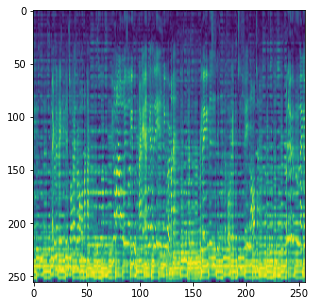

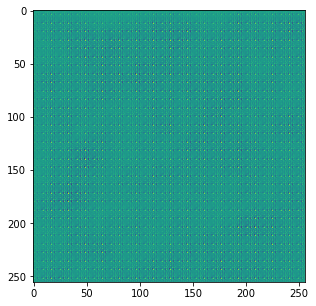

In [121]:
plt.figure(figsize=(15,5))
plt.imshow(test_img)
plt.show()
plt.figure(figsize=(15,5))
plt.imshow(np.array(prediction[0]*255))